                                                                                                Titanic Model

In [1]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
from sklearn.preprocessing import OneHotEncoder, LabelEncoder
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import RidgeCV, LassoCV, Ridge, Lasso
from sklearn.feature_selection import SelectFromModel
from sklearn.metrics import r2_score, mean_absolute_error, mean_squared_error
from sklearn.decomposition import PCA

KNNclassifier=KNeighborsClassifier(n_neighbors=5)
from sklearn.metrics import accuracy_score
from sklearn.metrics import confusion_matrix
from sklearn.svm import SVC
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import RandomForestClassifier

from sklearn.naive_bayes import GaussianNB


from keras.models import Sequential
from keras.layers import Dense, Activation, Dropout
import keras
from keras.optimizers import SGD
import graphviz

# Input data files are available in the "../input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# Any results you write to the current directory are saved as output.

Using TensorFlow backend.


/kaggle/input/titanic/gender_submission.csv
/kaggle/input/titanic/test.csv
/kaggle/input/titanic/train.csv


1. Training data Pre-preocessing

In [2]:
#Importing the training and testing data
train = pd.read_csv('../input/titanic/train.csv')
test = pd.read_csv('../input/titanic/test.csv')

In [3]:
#Checking the first five row in training data
train.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
#stats of the training data
train.describe()

,PassengerId,Survived,Pclass,Age,SibSp,Parch,Fare
count,891.000000,891.000000,891.000000,714.000000,891.000000,891.000000,891.000000
mean,446.000000,0.383838,2.308642,29.699118,0.523008,0.381594,32.204208
std,257.353842,0.486592,0.836071,14.526497,1.102743,0.806057,49.693429
min,1.000000,0.000000,1.000000,0.420000,0.000000,0.000000,0.000000
25%,223.500000,0.000000,2.000000,20.125000,0.000000,0.000000,7.910400
50%,446.000000,0.000000,3.000000,28.000000,0.000000,0.000000,14.454200
75%,668.500000,1.000000,3.000000,38.000000,1.000000,0.000000,31.000000
max,891.000000,1.000000,3.000000,80.000000,8.000000,6.000000,512.329200


In [5]:
#Familiarising with the Column name 
train.columns

Index(['PassengerId', 'Survived', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp',
       'Parch', 'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [6]:
#Checking the data type for better understanding
train.dtypes

PassengerId      int64
Survived         int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

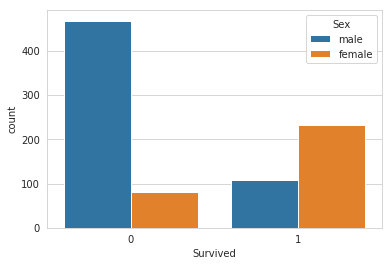

In [7]:
#countplot of survived by sex
sns.set_style('whitegrid')
sns.countplot(x='Survived',hue='Sex',data=train)

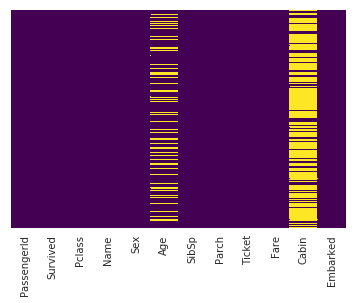

In [8]:
#Heatmap plot of the missing data or null present in the training data
sns.heatmap(train.isnull(),yticklabels=False,cmap='viridis',cbar=False)

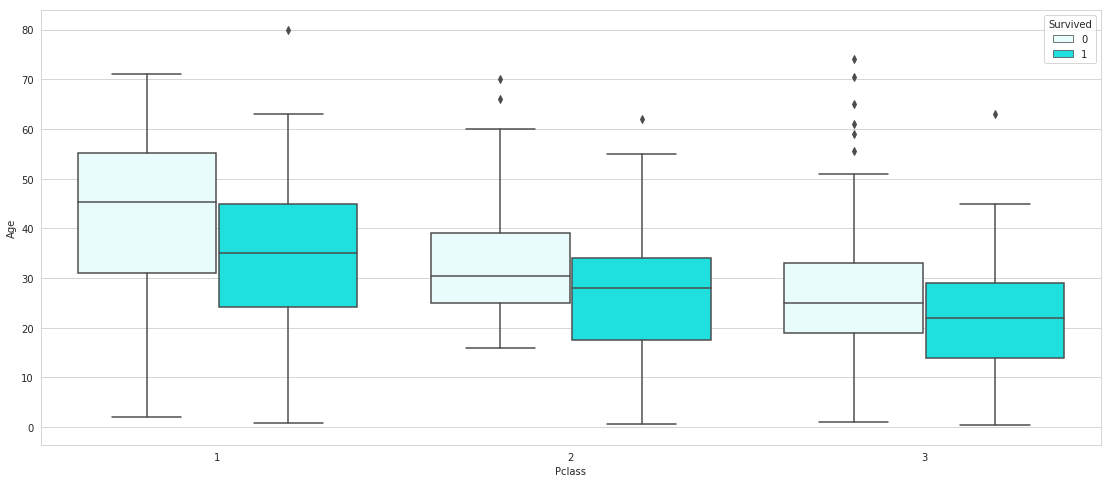

In [9]:
#Boxplot of the Pclass,Age and Survived 
plt.figure(figsize=(19, 8))
sns.boxplot(x='Pclass',y='Age',data=train,hue='Survived',color="cyan")

*  Feature Engineering

In [10]:
# total null presnets in the training data
train.isna().sum().max()

687

In [11]:
#Function fortotal null  present
def missing_total(data):
    missing_total= data.isna().sum().sort_values(ascending=False)
    return missing_total

In [12]:
#Function for null percentage present
def missing_percent(data):
    missing_percent = ((data.isna().sum()/data.isna().count())*100).sort_values(ascending=False)
    return missing_percent

In [13]:
#Table for null percentage and total null present
train_missing = pd.concat([missing_total(train), missing_percent(train)], axis=1, keys=['missing_total', 'missing_percent'])
train_missing.head(50)

,missing_total,missing_percent
Cabin,687,77.104377
Age,177,19.865320
Embarked,2,0.224467
Fare,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [14]:
#further anaylsis on missing train data
#Removing any columns that contains nan greater than 20% which is only cabin
train = train.drop((train_missing[train_missing['missing_percent'] > 20.0]).index,1)

In [15]:
#Fill the nan with median of the columns
#train.fillna(train.median(), inplace=True)

In [16]:
#complete embarked with mode
train['Embarked'].fillna(train['Embarked'].mode()[0], inplace = True)

In [17]:
#Function to create more feature as Age Category
def age_group(val):
    if val<2:
        return 'Infant'
    elif val>2 and val < 10:
        return 'Child'
    elif val>10 and val < 17:
        return 'Adolescence'
    elif val>17 and val < 24:
        return 'Teen'
    elif val>24 and val < 65:
        return 'Adult'
    else:
        return 'Elderly'
train['Age_category']=train['Age'].apply(age_group)

In [18]:
#Splitting the data into categorical data, float and Varaible
train_Var = train[train.dtypes[train.dtypes == "int64"].index]

train_Cat = train[train.dtypes[train.dtypes == "object"].index]

train_float = train[train.dtypes[train.dtypes == "float"].index]

In [19]:
#Creating more features from Name
train_Cat['Title'] = train_Cat['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
stat_min = 10
title_names = (train_Cat['Title'].value_counts() < stat_min)
train_Cat['Title'] = train_Cat['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(train_Cat['Title'].value_counts())
print("-"*10)

Mr        517
Miss      182
Mrs       125
Master     40
Misc       27
Name: Title, dtype: int64
----------


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [20]:
# dropping Name and Ticket columns name because they are not important for the analysis
drop_column = ['Name', 'Ticket']
train_Cat.drop(drop_column, axis=1, inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/frame.py:4117: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  errors=errors,


In [21]:
#Converting the categorical data into dummy variable for easy analysis
train_Cat = pd.get_dummies(train_Cat)

In [22]:
train_Cat.head(20)

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_category_Adolescence,Age_category_Adult,Age_category_Child,Age_category_Elderly,Age_category_Infant,Age_category_Teen,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,1,0
1,1,0,1,0,0,0,1,0,0,0,0,0,0,0,0,1
2,1,0,0,0,1,0,1,0,0,0,0,0,0,1,0,0
3,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
4,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
5,0,1,0,1,0,0,0,0,1,0,0,0,0,0,1,0
6,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
7,0,1,0,0,1,0,0,0,1,0,0,1,0,0,0,0
8,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
9,1,0,1,0,0,1,0,0,0,0,0,0,0,0,0,1


In [23]:
train_Var

,PassengerId,Survived,Pclass,SibSp,Parch
0,1,0,3,1,0
1,2,1,1,1,0
2,3,1,3,0,0
3,4,1,1,1,0
4,5,0,3,0,0
...,...,...,...,...,...
886,887,0,2,0,0
887,888,1,1,0,0
888,889,0,3,1,2
889,890,1,1,0,0


In [24]:
#Fill the nan with median of the columns
train_float['Age'].fillna(train_float['Age'].median(), inplace = True)

/opt/conda/lib/python3.6/site-packages/pandas/core/generic.py:6287: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  self._update_inplace(new_data)


In [25]:
#dropping the PassengerId becuase it is not important for the prediction
train_Var.drop('PassengerId', axis=1, inplace = True)

In [26]:
#concatinating the three data type together
inputData=train_Var.join([train_Cat, train_float])

In [27]:
#Checking for the last time the total null value available
inputData.isna().sum().max()

0

In [28]:
inputData.head()

,Survived,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_category_Adolescence,...,Age_category_Elderly,Age_category_Infant,Age_category_Teen,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,Age,Fare
0,0,3,1,0,0,1,0,0,1,0,...,0,0,1,0,0,0,1,0,22.0,7.2500
1,1,1,1,0,1,0,1,0,0,0,...,0,0,0,0,0,0,0,1,38.0,71.2833
2,1,3,0,0,1,0,0,0,1,0,...,0,0,0,0,0,1,0,0,26.0,7.9250
3,1,1,1,0,1,0,0,0,1,0,...,0,0,0,0,0,0,0,1,35.0,53.1000
4,0,3,0,0,0,1,0,0,1,0,...,0,0,0,0,0,0,1,0,35.0,8.0500


In [29]:
inputData.shape

(891, 22)

2.  Test Data data preprocessing

The same analysis will be performed on the testing data

In [30]:
#Checking the first five row in testing data
test.head()

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,NaN,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,NaN,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,NaN,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,NaN,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,NaN,S


In [31]:
#stats of the testing data
test.describe()

,PassengerId,Pclass,Age,SibSp,Parch,Fare
count,418.000000,418.000000,332.000000,418.000000,418.000000,417.000000
mean,1100.500000,2.265550,30.272590,0.447368,0.392344,35.627188
std,120.810458,0.841838,14.181209,0.896760,0.981429,55.907576
min,892.000000,1.000000,0.170000,0.000000,0.000000,0.000000
25%,996.250000,1.000000,21.000000,0.000000,0.000000,7.895800
50%,1100.500000,3.000000,27.000000,0.000000,0.000000,14.454200
75%,1204.750000,3.000000,39.000000,1.000000,0.000000,31.500000
max,1309.000000,3.000000,76.000000,8.000000,9.000000,512.329200


In [32]:
#Familiarising with the Column name 
test.columns

Index(['PassengerId', 'Pclass', 'Name', 'Sex', 'Age', 'SibSp', 'Parch',
       'Ticket', 'Fare', 'Cabin', 'Embarked'],
      dtype='object')

In [33]:
#Checking the data type for better understanding
test.dtypes

PassengerId      int64
Pclass           int64
Name            object
Sex             object
Age            float64
SibSp            int64
Parch            int64
Ticket          object
Fare           float64
Cabin           object
Embarked        object
dtype: object

In [34]:
# total null presnets in the testing data
test.isna().sum().max()

327

In [35]:
#Table for null percentage and total null present
test_missing = pd.concat([missing_total(test), missing_percent(test)], axis=1, keys=['missing_total', 'missing_percent'])
test_missing.head(50)

,missing_total,missing_percent
Cabin,327,78.229665
Age,86,20.574163
Fare,1,0.239234
Embarked,0,0.000000
Ticket,0,0.000000
Parch,0,0.000000
SibSp,0,0.000000
Sex,0,0.000000
Name,0,0.000000
Pclass,0,0.000000


In [36]:
#Removing any columns that contains nan greater than 20% which is only cabin
test = test.drop((test_missing[test_missing['missing_percent'] > 50.0]).index,1)

In [37]:
test.head(5)

,PassengerId,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Embarked
0,892,3,"Kelly, Mr. James",male,34.5,0,0,330911,7.8292,Q
1,893,3,"Wilkes, Mrs. James (Ellen Needs)",female,47.0,1,0,363272,7.0000,S
2,894,2,"Myles, Mr. Thomas Francis",male,62.0,0,0,240276,9.6875,Q
3,895,3,"Wirz, Mr. Albert",male,27.0,0,0,315154,8.6625,S
4,896,3,"Hirvonen, Mrs. Alexander (Helga E Lindqvist)",female,22.0,1,1,3101298,12.2875,S


In [38]:
drop_column = ['PassengerId', 'Ticket']
test.drop(drop_column, axis=1, inplace = True)

In [39]:
#Fill the nan with median of the columns
test['Age'].fillna(test['Age'].median(), inplace = True)
test['Fare'].fillna(test['Fare'].median(), inplace = True)

In [40]:
def age_cat(val):
    if val<2:
        return 'Infant'
    elif val>2 and val < 10:
        return 'Child'
    elif val>10 and val < 17:
        return 'Adolescence'
    elif val>17 and val < 24:
        return 'Teen'
    elif val>24 and val < 65:
        return 'Adult'
    else:
        return 'Elderly'
test['Age_category']=test['Age'].apply(age_cat)

In [41]:
#Splitting the data into categorical data and Varaible
test_Var = test[test.dtypes[test.dtypes == "int64"].index]

test_Cat = test[test.dtypes[test.dtypes == "object"].index]

test_float = test[test.dtypes[test.dtypes == "float"].index]

In [42]:
#Feature Engineering
test_Cat['Title'] = test_Cat['Name'].str.split(", ", expand=True)[1].str.split(".", expand=True)[0]
stat_min = 10
title_names = (test_Cat['Title'].value_counts() < stat_min)
test_Cat['Title'] = test_Cat['Title'].apply(lambda x: 'Misc' if title_names.loc[x] == True else x)
print(test_Cat['Title'].value_counts())
print("-"*10)

Mr        240
Miss       78
Mrs        72
Master     21
Misc        7
Name: Title, dtype: int64
----------


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  
/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  """


In [43]:
test_Cat.drop('Name', axis=1, inplace = True)

In [44]:
#Converting the categorical data into dummy variable for easy analysis
test_Cat = pd.get_dummies(test_Cat)

In [45]:
test_Cat.head(5)

,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_category_Adolescence,Age_category_Adult,Age_category_Child,Age_category_Elderly,Age_category_Infant,Age_category_Teen,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs
0,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
1,1,0,0,0,1,0,1,0,0,0,0,0,0,0,0,1
2,0,1,0,1,0,0,1,0,0,0,0,0,0,0,1,0
3,0,1,0,0,1,0,1,0,0,0,0,0,0,0,1,0
4,1,0,0,0,1,0,0,0,0,0,1,0,0,0,0,1


In [46]:
test_Cat.isna().sum().max()

0

In [47]:
outputData=test_Var.join([test_Cat, test_float])

In [48]:
outputData.head(5)

,Pclass,SibSp,Parch,Sex_female,Sex_male,Embarked_C,Embarked_Q,Embarked_S,Age_category_Adolescence,Age_category_Adult,...,Age_category_Elderly,Age_category_Infant,Age_category_Teen,Title_Master,Title_Misc,Title_Miss,Title_Mr,Title_Mrs,Age,Fare
0,3,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,34.5,7.8292
1,3,1,0,1,0,0,0,1,0,1,...,0,0,0,0,0,0,0,1,47.0,7.0000
2,2,0,0,0,1,0,1,0,0,1,...,0,0,0,0,0,0,1,0,62.0,9.6875
3,3,0,0,0,1,0,0,1,0,1,...,0,0,0,0,0,0,1,0,27.0,8.6625
4,3,1,1,1,0,0,0,1,0,0,...,0,0,1,0,0,0,0,1,22.0,12.2875


In [49]:
outputData.isna().sum().max()

0

Data Splitting

In [50]:
X_train = inputData.drop(['Survived'],axis=1).values
Y_train = inputData['Survived'].values
X_test =outputData.values

In [51]:
#Data Processing
#random seed------ Meaning of random seed is explained in the documentation
seed = 0
np.random.seed(seed)
X_training, X_testing, Y_training, Y_testing= train_test_split(X_train, Y_train.reshape(-1,1), test_size=0.1, random_state=seed)
X_scaler = MinMaxScaler()
Y_scaler = MinMaxScaler()

X_scaled_training = X_scaler.fit_transform(X_training)
Y_scaled_training = Y_scaler.fit_transform(Y_training)
X_scaled_testing = X_scaler.transform(X_testing)
Y_scaled_testing = Y_scaler.transform(Y_testing)
X_scaled_test = X_scaler.transform(X_test)

In [52]:
features_selection = LassoCV(0.5, cv=5)
reg = SelectFromModel(features_selection)
reg.fit(X_scaled_training, Y_scaled_training)

X_scaled_training = reg.transform(X_scaled_training)

#Printing the features selected
for feature_list_index in reg.get_support(indices=True):
    print([feature_list_index])

[3]
[17]


/opt/conda/lib/python3.6/site-packages/sklearn/linear_model/_coordinate_descent.py:1088: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [53]:
#Transforming the testing data to the actual number of features selected for the training data
X_scaled_testing = reg.transform(X_scaled_testing)
X_scaled_test = reg.transform(X_scaled_test)

In [54]:
KNNclassifier.fit(X_scaled_training ,Y_scaled_training)
y_pred = KNNclassifier.predict(X_scaled_testing)
print("Accuracy :",accuracy_score(Y_scaled_testing,y_pred)*100)
cm = confusion_matrix(Y_scaled_testing, y_pred)
print("Confusion Matrix:\n", cm)

Accuracy : 80.0
Confusion Matrix:
 [[45  6]
 [12 27]]


/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:1: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  """Entry point for launching an IPython kernel.


In [55]:
SVMlinear=SVC(kernel='linear')
SVMlinear.fit(X_scaled_training ,Y_scaled_training)
y_pred = SVMlinear.predict(X_scaled_testing)
print("Accuracy :",accuracy_score(Y_scaled_testing,y_pred)*100)
cm = confusion_matrix(Y_scaled_testing,y_pred)
print("Confusion Matrix:\n", cm)

Accuracy : 80.0
Confusion Matrix:
 [[45  6]
 [12 27]]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [56]:
SVMrbf=SVC(kernel='rbf')
SVMrbf.fit(X_scaled_training ,Y_scaled_training)
y_pred = SVMrbf.predict(X_scaled_testing)
print("Accuracy :",accuracy_score(Y_scaled_testing,y_pred)*100)
cm = confusion_matrix(Y_scaled_testing,y_pred)
print("Confusion Matrix:\n", cm)

Accuracy : 80.0
Confusion Matrix:
 [[45  6]
 [12 27]]


/opt/conda/lib/python3.6/site-packages/sklearn/utils/validation.py:760: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [57]:
NB=GaussianNB()
NB.fit(X_scaled_training ,Y_scaled_training)
y_pred = NB.predict(X_scaled_testing)
print("Accuracy :",accuracy_score(Y_scaled_testing,y_pred)*100)
cm = confusion_matrix(Y_scaled_testing,y_pred)
print("Confusion Matrix:\n", cm)

Accuracy : 76.66666666666667
Confusion Matrix:
 [[39 12]
 [ 9 30]]


/opt/conda/lib/python3.6/site-packages/sklearn/naive_bayes.py:206: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)


In [58]:
DecisionTree=DecisionTreeClassifier(criterion='entropy',random_state=23)
DecisionTree.fit(X_scaled_training ,Y_scaled_training)
y_pred = DecisionTree.predict(X_scaled_testing)
print("Accuracy :",accuracy_score(Y_scaled_testing,y_pred)*100)
cm = confusion_matrix(Y_scaled_testing,y_pred)
print("Confusion Matrix:\n", cm)

Accuracy : 80.0
Confusion Matrix:
 [[45  6]
 [12 27]]


In [59]:
RFC=RandomForestClassifier(n_estimators=17,criterion='entropy',random_state=0)
RFC.fit(X_scaled_training ,Y_scaled_training)
y_pred = RFC.predict(X_scaled_testing)
print("Accuracy :",accuracy_score(Y_scaled_testing,y_pred)*100)
cm = confusion_matrix(Y_scaled_testing,y_pred)
print("Confusion Matrix:\n", cm)

/opt/conda/lib/python3.6/site-packages/ipykernel_launcher.py:2: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples,), for example using ravel().
  


Accuracy : 80.0
Confusion Matrix:
 [[45  6]
 [12 27]]


In [60]:
model = Sequential()

# Inputing the first layer with input dimensions
model.add(Dense(100, 
                activation='relu',  
                input_dim=X_scaled_training.shape[1],
                kernel_initializer='uniform'))

model.add(Dense(20,
                kernel_initializer='uniform',
                activation='relu'))

#adding second hidden layer 
model.add(Dense(1,
                kernel_initializer='uniform',
                activation='sigmoid'))
#With such a scalar sigmoid output on a binary classification problem, the loss
#function you should use is binary_crossentropy

#Visualizing the model
model.summary()

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               300       
_________________________________________________________________
dense_2 (Dense)              (None, 20)                2020      
_________________________________________________________________
dense_3 (Dense)              (None, 1)                 21        
Total params: 2,341
Trainable params: 2,341
Non-trainable params: 0
_________________________________________________________________


In [61]:
#Creating an Stochastic Gradient Descent
sgd = SGD(lr = 0.01, momentum = 0.9)

# Compiling our model
model.compile(optimizer = sgd, 
                   loss = 'binary_crossentropy', 
                   metrics = ['accuracy'])
# Fitting the ANN to the Training set
model.fit(X_scaled_training ,Y_scaled_training, 
               batch_size = 70, 
               epochs = 120, verbose=2)

Epoch 1/120
 - 0s - loss: 0.6908 - accuracy: 0.5880
Epoch 2/120
 - 0s - loss: 0.6813 - accuracy: 0.6217
Epoch 3/120
 - 0s - loss: 0.6733 - accuracy: 0.6217
Epoch 4/120
 - 0s - loss: 0.6673 - accuracy: 0.6217
Epoch 5/120
 - 0s - loss: 0.6652 - accuracy: 0.6217
Epoch 6/120
 - 0s - loss: 0.6642 - accuracy: 0.6217
Epoch 7/120
 - 0s - loss: 0.6634 - accuracy: 0.6217
Epoch 8/120
 - 0s - loss: 0.6631 - accuracy: 0.6217
Epoch 9/120
 - 0s - loss: 0.6630 - accuracy: 0.6217
Epoch 10/120
 - 0s - loss: 0.6630 - accuracy: 0.6217
Epoch 11/120
 - 0s - loss: 0.6628 - accuracy: 0.6217
Epoch 12/120
 - 0s - loss: 0.6628 - accuracy: 0.6217
Epoch 13/120
 - 0s - loss: 0.6627 - accuracy: 0.6217
Epoch 14/120
 - 0s - loss: 0.6627 - accuracy: 0.6217
Epoch 15/120
 - 0s - loss: 0.6625 - accuracy: 0.6217
Epoch 16/120
 - 0s - loss: 0.6624 - accuracy: 0.6217
Epoch 17/120
 - 0s - loss: 0.6622 - accuracy: 0.6217
Epoch 18/120
 - 0s - loss: 0.6621 - accuracy: 0.6217
Epoch 19/120
 - 0s - loss: 0.6620 - accuracy: 0.6217
Ep

In [62]:
#Using KNNclassifier for final prediction 
yhat =SVMrbf.predict(X_scaled_test).astype(int)

In [63]:
#Transforming the prediction back to normal data before scaling
prediction = Y_scaler.inverse_transform(yhat.reshape(-1,1)).astype(int)

In [64]:
Id = pd.read_csv('../input/titanic/test.csv')
Prediction = pd.concat([pd.DataFrame(Id['PassengerId'], columns=['PassengerId']),pd.DataFrame(yhat, columns=['Survived'])],axis=1)

In [65]:
Prediction

,PassengerId,Survived
0,892,0
1,893,1
2,894,0
3,895,0
4,896,1
...,...,...
413,1305,0
414,1306,1
415,1307,0
416,1308,0
